In [2]:
%matplotlib inline
import pandas as pd

In [3]:
df1 = pd.read_csv('input/house.csv')
df1.head(3)

,Price,Location,Type,Area,Building,Walk,Years
0,1620,江戸川区,3DK,50.25,52.31,10.0,39.0
1,3840,江戸川区,3LDK,82.62,95.60,20.0,28.0
2,4490,杉並区,3DK,46.81,76.60,13.0,22.0


In [4]:
# include='all'とすると、文字列も含め要約統計量を確認
df1.describe(include='all')

,Price,Location,Type,Area,Building,Walk,Years
count,147.000000,147,147,147.000000,147.000000,147.000000,147.000000
unique,NaN,4,13,NaN,NaN,NaN,NaN
top,NaN,世田谷区,3LDK,NaN,NaN,NaN,NaN
freq,NaN,62,45,NaN,NaN,NaN,NaN
mean,6965.775510,NaN,NaN,97.386667,109.255918,10.945578,21.020408
std,5556.659261,NaN,NaN,70.421412,67.794527,6.049773,14.231679
min,1310.000000,NaN,NaN,22.120000,29.330000,0.000000,0.000000
25%,4000.000000,NaN,NaN,53.490000,70.570000,7.000000,10.500000
50%,5140.000000,NaN,NaN,76.170000,90.830000,10.000000,20.000000
75%,7035.000000,NaN,NaN,107.095000,114.950000,14.000000,29.000000


In [5]:
# 欠損値を確認
df1.isnull().sum()

Price       0
Location    0
Type        0
Area        0
Building    0
Walk        0
Years       0
dtype: int64

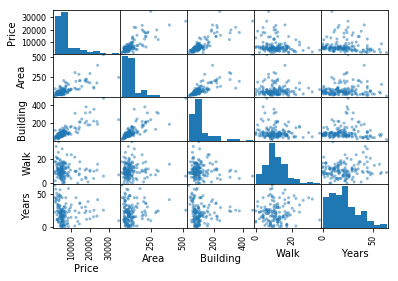

In [6]:
# データ全体の散布図行列を確認
pd.plotting.scatter_matrix(df1);

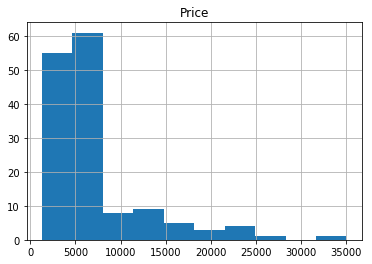

In [7]:
# 住宅価格（教師ラベル）のヒストグラム
df1[['Price']].hist();

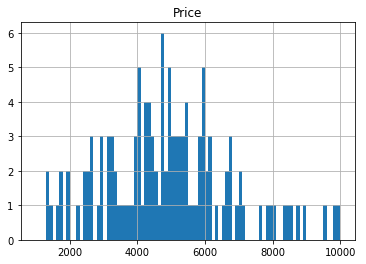

In [8]:
# 上のヒストグラムを確認すると7000前後で頻度に大きな違いが見られる。より細かく確認するためにbins幅を狭める(1000万円から1億円の範囲)
df1[['Price']].hist(range=(1000, 10000), bins=90);

In [9]:
# 度数で確認
# pandas.cut(データ, データ区間)で、データ区間でカテゴライズできる。
# データ区間に存在しない場合nanになるので、dropnaで削除する。
pd.cut(df1.Price, range(7000, 8000, 100)).dropna().sort_values()

8     (7000, 7100]
69    (7000, 7100]
51    (7100, 7200]
52    (7600, 7700]
53    (7800, 7900]
Name: Price, dtype: category
Categories (9, interval[int64]): [(7000, 7100] < (7100, 7200] < (7200, 7300] < (7300, 7400] ... (7500, 7600] < (7600, 7700] < (7700, 7800] < (7800, 7900]]

In [10]:
# 7200から7600の間にデータがない。
# 頻度に大きな差があるのでまとめて予測することは難しい。
# よって7200以下のデータを用いる

df2 = df1[df1.Price <= 7200]
df2.shape

(112, 7)

In [11]:
# 相関係数行列を表示
df2.corr()

,Price,Area,Building,Walk,Years
Price,1.000000,0.456507,0.554203,-0.217603,-0.443185
Area,0.456507,1.000000,0.677117,0.149516,-0.097824
Building,0.554203,0.677117,1.000000,-0.058664,-0.230042
Walk,-0.217603,0.149516,-0.058664,1.000000,0.134271
Years,-0.443185,-0.097824,-0.230042,0.134271,1.000000


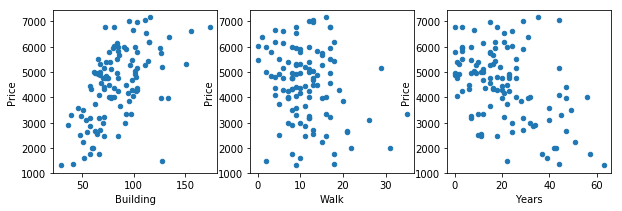

In [12]:
# Priceとの散布図
for i, col in enumerate(['Building', 'Walk', 'Years'], 1):
    df2.plot(col, 'Price', kind='scatter',
             figsize=(10, 3), ax=plt.subplot(1, 3, i))

In [13]:
# DataFrame.drop(列名リスト, 1)で列名削除した新しいDataFrame作成
# PriceとWalkの相関は-0.22と低いため説明変数から除外
# AreaとBuildingの相関係数は0.68でやや強い相関があり、多重共線性がある。
# Priceと比べた時Buildingの方が相関係数の絶対値が大きいため、Areaを除外
df3 = df2.drop(['Area', 'Walk'], 1)
df3.head(3)

,Price,Location,Type,Building,Years
0,1620,江戸川区,3DK,52.31,39.0
1,3840,江戸川区,3LDK,95.60,28.0
2,4490,杉並区,3DK,76.60,22.0


## Locationを数値データにして回帰モデルで使えるようにする

In [14]:
# Locationごとのデータの個数
df3.Location.value_counts()

世田谷区    38
杉並区     38
江戸川区    22
葛飾区     14
Name: Location, dtype: int64

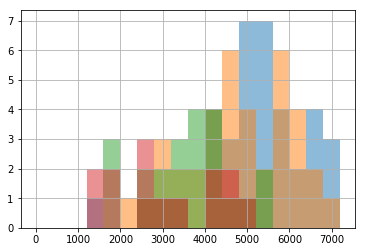

In [15]:
# ヒストグラムで確認すると4つの区で分布に差があることがわかる
g_price = df3.groupby('Location').Price
g_price.hist(alpha=0.5, range=(0, 7200), bins=18);

In [16]:
# Locationの値ごとのPriceの平均
g_price.mean()

Location
世田谷区    5224.473684
杉並区     4808.421053
江戸川区    3576.727273
葛飾区     3097.214286
Name: Price, dtype: float64

In [29]:
# 区ごとに値を設定
df4 = df3.drop('Location', 1)
df4['Loc'] = df3.Location.map({
    '世田谷区': 'High', 
    '杉並区': 'High', 
    '江戸川区':'Low',
    '葛飾区': 'Low'
})

In [30]:
df4[:4]

,Price,Type,Building,Years,Loc
0,1620,3DK,52.31,39.0,Low
1,3840,3LDK,95.60,28.0,Low
2,4490,3DK,76.60,22.0,High
3,5400,2LDK,77.05,10.0,High


In [31]:
# Locのようなカテゴリデータから値に応じて0-1の新しい列を作るにはpandas.get_dummiesを利用する
df4 = pd.get_dummies(df4, columns=['Loc'], drop_first=True)

In [32]:
df4[:4]

,Price,Type,Building,Years,Loc_Low
0,1620,3DK,52.31,39.0,1
1,3840,3LDK,95.60,28.0,1
2,4490,3DK,76.60,22.0,0
3,5400,2LDK,77.05,10.0,0


## 間取り（Type）を数値データ化

In [33]:
df4.Type.value_counts()

3LDK    33
4LDK    24
2LDK    24
3DK     14
2DK      5
5LDK     4
1LDK     4
4DK      2
5DK      1
6LDK     1
Name: Type, dtype: int64

In [34]:
# Typeを3パターンに分類し、Planとして追加
df5 = df4.drop('Type', 1)
df5['Plan'] = pd.cut(df4.Type.str[0].astype(int), [0, 2,3,6], labels=['Small', 'Normal', 'Large'])
df5.Plan.value_counts()

Normal    47
Small     33
Large     32
Name: Plan, dtype: int64

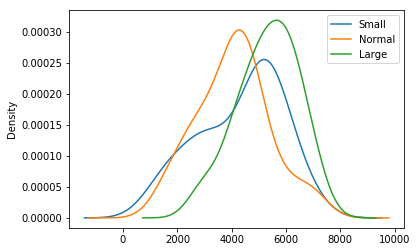

In [35]:
# カーネル密度推定のグラフを作成する
# カーネル密度推定は確率変数の確率密度関数を推定する方法
g_price = df5.groupby('Plan').Price
g_price.plot.kde(legend=True);

In [36]:
g_price.mean()

Plan
Small     4316.060606
Normal    4058.531915
Large     5316.187500
Name: Price, dtype: float64

In [37]:
df5 = pd.get_dummies(df5, columns=['Plan'], drop_first=True)

In [38]:
df5[:4]

,Price,Building,Years,Loc_Low,Plan_Normal,Plan_Large
0,1620,52.31,39.0,1,1,0
1,3840,95.60,28.0,1,1,0
2,4490,76.60,22.0,0,1,0
3,5400,77.05,10.0,0,0,0
